# Capstone

## Introduction etc etc

***
***

# Imports, Loading Data

In [1]:
#imports
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import re
import string
import seaborn as sns
import nltk
import cv2
from scipy import spatial
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from gensim.models import Word2Vec, word2vec
from mpl_toolkits.axes_grid1 import ImageGrid
from wordcloud import WordCloud

#models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras import preprocessing
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from keras_preprocessing.sequence import pad_sequences


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

##### explain datset in detail

In [2]:
data_dir_depression = './data/depression_dataset_reddit_cleaned.csv'

depression_df = pd.read_csv(data_dir_depression)

# EDA and Preprocessing

## Exploratory Data Analysis

In [3]:
#change to df for ease of use
df = depression_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [4]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [5]:
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

In [6]:
df['is_depression'].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

##### ______ discuss balance_____________________

In [7]:
df['islowercase'] = list(map(lambda x: x.islower(), df['clean_text']))
df['islowercase'].value_counts()

True    7731
Name: islowercase, dtype: int64

## Preprocessing Data

Explain __________________________________________________________________________________________

will create variations of columns to be able to experiment with different options (with/without stopwords, etc)

### Lowercase Text

In this case, the text data from the downloaded dataset is already lowercase, so we do not need to take this step!

In [8]:
# df['lower_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# df['lower_text'].head()

### Tokenize
Explain __________________________________________________________________________________________

In [9]:
def tokenize_data(data):
    
    #(this regex code keeps words with apostrophes as single tokens)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    #create tokens
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens]

In [10]:
df['tokenized'] = df.apply(lambda x: tokenize_data(x['clean_text']), axis=1)
df['tokenized'].head()

0    [we, understand, that, most, people, who, repl...
1    [welcome, to, r, depression, s, check, in, pos...
2    [anyone, else, instead, of, sleeping, more, wh...
3    [i, ve, kind, of, stuffed, around, a, lot, in,...
4    [sleep, is, my, greatest, and, most, comfortin...
Name: tokenized, dtype: object

### Stopwords
Explain __________________________________________________________________________________________

In [11]:
#show top FreqDist of Tokenized Column
FreqDist(sum(df['tokenized'], [])).most_common(30)

[('i', 40411),
 ('to', 17965),
 ('and', 16326),
 ('a', 12638),
 ('the', 11932),
 ('my', 11430),
 ('it', 9976),
 ('of', 7738),
 ('t', 7698),
 ('me', 6941),
 ('that', 6506),
 ('in', 6088),
 ('m', 5758),
 ('but', 5427),
 ('is', 5324),
 ('for', 5196),
 ('have', 5007),
 ('this', 4557),
 ('just', 4527),
 ('so', 4337),
 ('s', 4073),
 ('with', 3869),
 ('wa', 3810),
 ('like', 3584),
 ('not', 3275),
 ('feel', 3227),
 ('can', 3217),
 ('be', 3158),
 ('on', 3075),
 ('don', 3029)]

In [12]:
stops = stopwords.words('english')

#add punctuation
for symbol in ",.'?!()":
    stops += symbol

    #show example of stopwords list
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
def tokenize_remove_stops(data):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens if word not in stops]

In [14]:
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

#show difference
df[['tokenized','tokenized_no_stops']].head()

,tokenized,tokenized_no_stops
0,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i..."
1,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t..."
2,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s..."
3,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i..."
4,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever..."


In [15]:
#show top FreqDist now that stopwords are removed!
freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(30)

[('wa', 3810),
 ('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660),
 ('really', 1617),
 ('depression', 1569),
 ('anxiety', 1548),
 ('thing', 1534),
 ('one', 1522),
 ('year', 1438),
 ('go', 1398),
 ('friend', 1297),
 ('would', 1285),
 ('think', 1280),
 ('going', 1252),
 ('ha', 1243),
 ('make', 1210),
 ('much', 1131),
 ('never', 1114),
 ('work', 1093),
 ('back', 1049),
 ('help', 1022),
 ('feeling', 948)]

##### explain wa, etc __________________________________________________________

In [16]:
stops.extend(['wa'])
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(10)

[('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660)]

##### show size diff _______________________________________________________

### Lemmatization
explain __________________________________________________________________________________________

In [17]:
lemmatizer = WordNetLemmatizer()

def lemmatize_data(data):
    return [lemmatizer.lemmatize(word) for word in data]

In [18]:
df['lemmatized_no_stops'] = df['tokenized_no_stops'].apply(lemmatize_data)
df['lemmatized_no_stops'].head()

0    [understand, people, reply, immediately, op, i...
1    [welcome, r, depression, check, post, place, t...
2    [anyone, else, instead, sleeping, depressed, s...
3    [kind, stuffed, around, lot, life, delaying, i...
4    [sleep, greatest, comforting, escape, whenever...
Name: lemmatized_no_stops, dtype: object

#### Rejoining Words
final step for later use, explain

In [19]:
def rejoin_words(column):
    return ( " ".join(column))

df['rejoined']= df.apply(lambda x: rejoin_words(x['lemmatized_no_stops']), axis=1)
df['rejoined']

0       understand people reply immediately op invitat...
1       welcome r depression check post place take mom...
2       anyone else instead sleeping depressed stay ni...
3       kind stuffed around lot life delaying inevitab...
4       sleep greatest comforting escape whenever wake...
                              ...                        
7726                                                 snow
7727                                 moulin rouge mad cry
7728                        trying shout find people list
7729    ughh find red sox hat got ta wear creepy nick ...
7730    slept wonderfully finally tried swatching new ...
Name: rejoined, Length: 7731, dtype: object

### The Peprocessed Dataset
##### explain _______________________________________

In [20]:
#show df minus the columns we dont need for this analysis
df[['clean_text', 'rejoined']].head()

,clean_text,rejoined
0,we understand that most people who reply immed...,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,sleep greatest comforting escape whenever wake...


#### Check for Significant Words in Corpus

specifically words that (to a human observer) may be dead giveaways for depression

In [21]:
depressed_df = df[df['is_depression']==1]
undiag_df = df[df['is_depression']==0]

depressed_top = FreqDist(sum(depressed_df['tokenized_no_stops'], [])).most_common(50)
undiag_top = FreqDist(sum(undiag_df['tokenized_no_stops'], [])).most_common(50)

depressed_top = pd.Series(dict(depressed_top))
undiag_top = pd.Series(dict(undiag_top))

In [22]:
depressed_top

like          3398
feel          3115
know          2153
want          2135
life          2109
get           2084
time          1908
even          1751
people        1603
depression    1569
anxiety       1545
really        1480
thing         1460
day           1447
year          1395
one           1373
friend        1249
would         1224
go            1183
think         1180
make          1132
ha            1087
going         1083
never         1067
much          1018
help           985
back           882
thought        881
feeling        878
work           823
im             814
way            792
anything       786
always         765
everything     765
anyone         762
still          747
something      741
got            732
every          703
bad            702
anymore        701
also           697
better         690
see            690
good           689
could          684
need           667
someone        646
nothing        639
dtype: int64

In [23]:
undiag_top

work        270
day         241
get         232
go          215
today       192
like        186
got         183
sleep       179
going       169
back        167
time        161
want        157
ha          156
need        151
still       150
one         149
quot        145
sad         138
really      137
good        130
know        130
http        126
im          125
miss        118
u           117
oh          114
much        113
night       113
feel        112
com         109
morning     109
lol         107
sorry       103
think       100
na          100
bad         100
twitter      99
last         96
well         95
amp          94
see          92
home         92
hate         88
sick         87
love         84
hope         83
tomorrow     82
new          82
bed          82
wish         81
dtype: int64

In [24]:
depressed_top.index

Index(['like', 'feel', 'know', 'want', 'life', 'get', 'time', 'even', 'people',
       'depression', 'anxiety', 'really', 'thing', 'day', 'year', 'one',
       'friend', 'would', 'go', 'think', 'make', 'ha', 'going', 'never',
       'much', 'help', 'back', 'thought', 'feeling', 'work', 'im', 'way',
       'anything', 'always', 'everything', 'anyone', 'still', 'something',
       'got', 'every', 'bad', 'anymore', 'also', 'better', 'see', 'good',
       'could', 'need', 'someone', 'nothing'],
      dtype='object')

In [25]:
for x in depressed_top.index:
    if x in undiag_top.index:
        depressed_top.pop(x)
depressed_top

life          2109
even          1751
people        1603
depression    1569
anxiety       1545
thing         1460
year          1395
friend        1249
would         1224
make          1132
never         1067
help           985
thought        881
feeling        878
way            792
anything       786
always         765
everything     765
anyone         762
something      741
every          703
anymore        701
also           697
better         690
could          684
someone        646
nothing        639
dtype: int64

##### PLOT ________________________________________

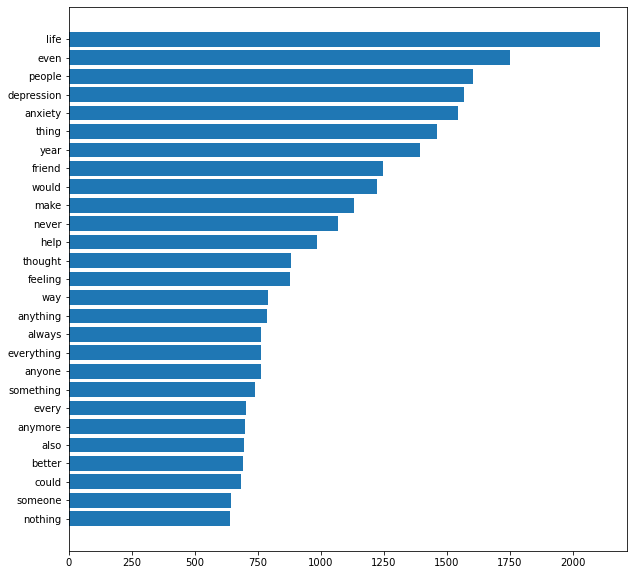

In [26]:
fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(depressed_top.index, depressed_top.values)
 
# Show Plot
plt.show()

##### explanation _______________________________________________________

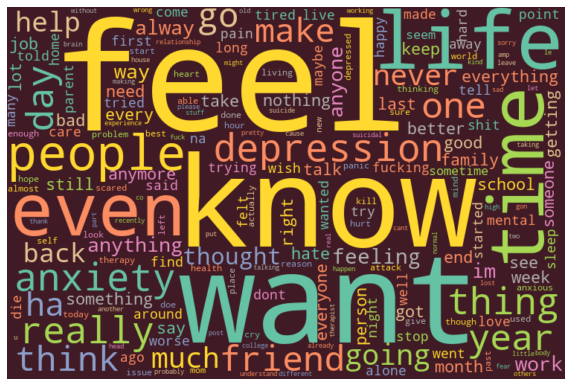

In [27]:
#word cloud:
rejoined = depressed_df.apply(lambda x: rejoin_words(x['tokenized_no_stops']), axis=1)
words = ' '.join([content for content in rejoined])

wordcloud = WordCloud(width=750, height=500, random_state=42, max_font_size=200, background_color='#401a24', colormap='Set2', collocations=False).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

imgName= 'cloud-Depression'
wordcloud.to_file('./img/'+imgName+'.png')

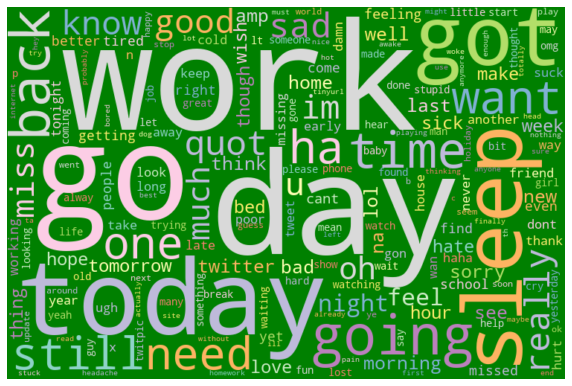

In [28]:
#word cloud:
rejoined = undiag_df.apply(lambda x: rejoin_words(x['tokenized_no_stops']), axis=1)
words = ' '.join([content for content in rejoined])

wordcloud = WordCloud(width=750, height=500, random_state=42, max_font_size=200, background_color='green', colormap='Set3', collocations=False).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

imgName= 'cloud-Undiag'
wordcloud.to_file('./img/'+imgName+'.png')

##### ________________Explain

# Modeling

##### __EXPLAIN STARTING FEATURE CHOICE, TARGET, ETC__
## ____

what "simple data" means

also talk about data sizes

starting original

### Splitting Data

In [29]:
X = df['clean_text']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### explain vectorizer

discuss max features

In [30]:
#max features 100 as a starting point
vectorizer = TfidfVectorizer(max_features=100)

X_train_vectorized = vectorizer.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names())

,about,all,always,am,an,and,anxiety,any,anyone,are,...,we,what,when,who,will,with,work,would,year,you
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.538367,0.000000,0.451680,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.188074,0.035935,0.049669,0.0,0.0,0.314132,0.042052,0.179436,0.000000,0.0,...,0.000000,0.075859,0.080886,0.047301,0.0,0.065732,0.0,0.044510,0.086666,0.036945
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.188034,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.346354,0.000000,0.287489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,0.000000,0.087283,0.000000,0.0,0.0,0.176076,0.000000,0.000000,0.000000,0.0,...,0.000000,0.092127,0.000000,0.000000,0.0,0.159657,0.0,0.000000,0.000000,0.000000
6180,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6181,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.838652
6182,0.000000,0.000000,0.000000,0.0,0.0,0.242542,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


### Metrics and Scoring
explain metric options

explain all in this context, but focus on acc, record other scores as well

ideal scores

In [31]:
#create score df
score_df = pd.DataFrame(columns = ['Name','Accuracy', 'Recall', 'Precision', 'F1'])

In [32]:
def update_score_df(name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 =f1_score(y_test, y_pred)
    
    #create new df entry
    entry = {'Name': name, 'Accuracy': acc, 'Recall': recall, 'Precision': prec, 'F1':f1}
    #print('adding: ',entry)
    return entry

## Baseline Model
explain model choice


In [33]:
#model name for score keeping
model_name = 'Baseline - MultiNB'

nb_model = MultinomialNB()

baseline_cv = cross_val_score(nb_model, X_train_vectorized, y_train)
baseline_cv

array([0.8367017 , 0.82053355, 0.82295877, 0.82700081, 0.82281553])

##### explain cross val score, why its so high _______________________________________

In [34]:
#reminder that true values are balanced evenly:
y_train.value_counts(normalize=True)

0    0.504528
1    0.495472
Name: is_depression, dtype: float64

### Evaluate Model on Test Data

In [35]:
#fit model to train data
nb_model.fit(X_train_vectorized, y_train)

#vectorize test data
vectorizer = TfidfVectorizer(max_features=100)
X_test_vectorized = vectorizer.fit_transform(X_test)

#predict on test data
y_pred = nb_model.predict(X_test_vectorized)

In [36]:
# create confusion matrix helper function:
def plot_confusion(name):

    #confusion matrix for test data
    conf_matrix = confusion_matrix(y_test,y_pred)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(name)

    plt.savefig('./img/'+name+'.png')
    plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       780
           1       0.67      0.72      0.69       767

    accuracy                           0.68      1547
   macro avg       0.68      0.68      0.68      1547
weighted avg       0.68      0.68      0.68      1547



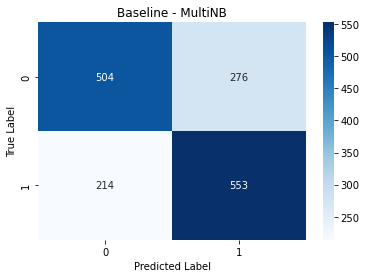

In [38]:
plot_confusion(model_name)

In [39]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982


##### explanation of results _____________________________________________________



##### coefficients etc ____________________________

In [40]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = vectorizer.get_feature_names()
coefficient_df['coefficients'] = nb_model.coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
5,anxiety,-3.163521
83,to,-3.189721
53,my,-3.515957
73,the,-3.525194
44,it,-3.557619
...,...,...
75,then,-5.486237
55,never,-5.491389
96,work,-5.491833
2,am,-5.517768


##### further detail about problematic "giveaway" words _______________________________________________________________________

look at again after stop words out of the way

##### explain min_df and max_df as well _________________________________________________

### Baseline Model with Preprocessed Data

explain

##### Rejoin Data _____________________________explain why_________________________________________________

for tfidf vectorizer

In [41]:
#model name for score keeping
model_name = 'Baseline No Stops'

X = df['rejoined']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



##### explain pipeline ________________________________________________________

vectorizes as part of process

In [42]:
#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       780
           1       0.81      0.87      0.84       767

    accuracy                           0.83      1547
   macro avg       0.83      0.83      0.83      1547
weighted avg       0.84      0.83      0.83      1547



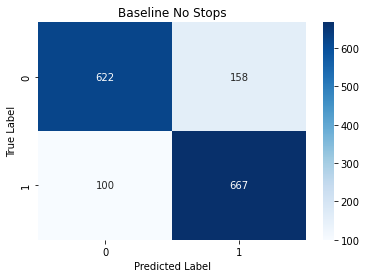

In [43]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [44]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940


##### explain _________________________________---

identify how removal of stop words increased model performance

##### One more look at coefficients ______________________________________________________________

In [45]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
15,depression,-2.928570
50,like,-3.506931
26,feel,-3.575731
2,anxiety,-3.714187
47,know,-3.889332
91,want,-3.892280
49,life,-3.899135
33,get,-3.937124
65,people,-4.037960
85,time,-4.053519


### Attempt One More Time with Subjective Alterations

go over subjective nature, etc

##### ______________________________________________

In [46]:
#same as stopword removal but our own list
def remove_some_words(data):
    words = ['depression', 'feel', 'anxiety']
    return [word for word in data if word not in words]

In [47]:
#remove words from lemmatized dataset without stopwords
df['subjective_removal'] = df.apply(lambda x: remove_some_words(x['lemmatized_no_stops']), axis=1)

#rejoin again for vectorizer!
df['rejoined_post_removal']= df.apply(lambda x: rejoin_words(x['subjective_removal']), axis=1)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       780
           1       0.75      0.73      0.74       767

    accuracy                           0.74      1547
   macro avg       0.74      0.74      0.74      1547
weighted avg       0.74      0.74      0.74      1547



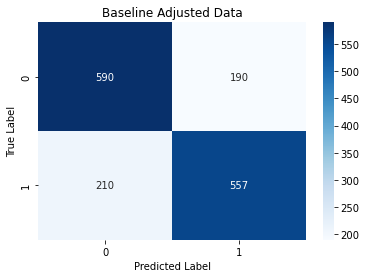

In [48]:
#model name for score keeping
model_name = 'Baseline Adjusted Data'

#repeat pipeline with new data
X = df['rejoined_post_removal']
y = df['is_depression']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', MultinomialNB())
                         ])

#fit to data
pipe.fit(X_train, y_train)

#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [49]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799


comment on scoring, slightly less accuract, etc 
##### __________

In [50]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

C:\Users\shade\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,feature,coefficients
48,like,-3.397138
45,know,-3.797430
91,want,-3.810001
47,life,-3.811550
30,get,-3.832728
63,people,-3.925495
85,time,-3.961266
18,even,-4.037119
62,one,-4.069629
13,day,-4.114895


##### commentary __________________________________________

## Model 2 - MultinomialNB (Tuned)


##### explain gridsearch

##### explain parameters

In [51]:
#example with tfidf:

#TfidfVectorizer:
tfidf_params = {
    'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__max_features': (None, 50, 100, 200, 300)
}

##### explain

In [52]:
#model name for score keeping
model_name = 'Tuned MNB'

#parameters:
model_params = {
    'clf__alpha': (1e-3, 1e-2, 1e-1, 1)
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', MultinomialNB())])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__alpha': (0.001, 0.01, 0.1, 1)}],
             scoring='accuracy', verbose=True)

In [53]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'clf__alpha': 0.1}

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       780
           1       0.80      0.96      0.88       767

    accuracy                           0.86      1547
   macro avg       0.88      0.87      0.86      1547
weighted avg       0.88      0.86      0.86      1547



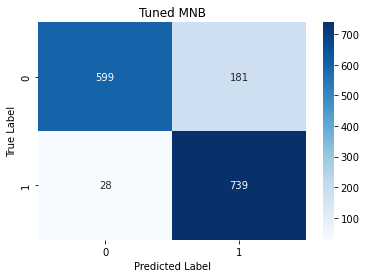

In [54]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [55]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111


##### talk about results _________________________________________

## Model 3 - Logistic Regression

In [56]:
#model name for score keeping
model_name = 'LogReg'

#parameters:
model_params = {
    'clf__C': np.logspace(-2, 2, 10),
    'clf__penalty': ['l1', 'l2']
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', LogisticRegression(random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\shade\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.89747772 0.88922921 0.87144098 0.80304003 0.80304003 0.80304003
 0.81775566 0.81856407 0.81791734 0.85737286 0.8570495  0.85737312
 0.86885565 0.86950237 0.869826   0.89747772 0.88922921 0.87144098
 0.80304003 0.80304003 0.80304003 0.81775566 0.81856407 0.81791734
 0.85737286 0.8570495  0.85737312 0.86885565 0.86950237 0.869826
 0.89747772 0.88922921 0.87144098 0.80304003 0.80304003 0.80304003
 0.81775566 0.81856407 0.81791734 0.85737286 0.8570495  0.85737312
 0.86885565 0.86950237 0.869826   0.89747772 0.88922921 0.87144098
 0.80304003 0.80304003 0.80304003 0.81775566 0.81856407 0.81791734
 0.85737286 0.8570495  0.85737312 0.86885565 0.86950237 0.869826
        nan 0.82891325        nan 0.83958633        nan 0.85365471
        nan 0.87467749        nan 0.89214183        nan 0.90265179
        nan 0.90766365        nan 0.9052383         nan 0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                          'clf__penalty': ['l1', 'l2']}],
             scoring='accuracy', verbose=True)

In [57]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'clf__C': 4.6415888336127775, 'clf__penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       780
           1       0.94      0.89      0.91       767

    accuracy                           0.92      1547
   macro avg       0.92      0.92      0.92      1547
weighted avg       0.92      0.92      0.92      1547



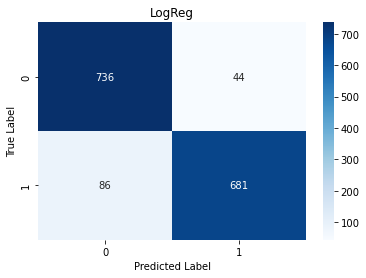

In [58]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [59]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869


##### talk about results _________________________________________

## Model 4 - Decision Tree

In [60]:
#model name for score keeping
model_name = 'Decision Tree'

#parameters:
model_params = {
    'clf__max_depth': [2, 3, 5, 10, 20],
    'clf__min_samples_leaf': [5, 10, 20, 50, 100],
    'clf__criterion': ["gini", "entropy"]
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', DecisionTreeClassifier(random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [2, 3, 5, 10, 20],
                          'clf__min_samples_leaf': [5, 10, 20, 50, 100]}],
             scoring='accuracy', verbose=True)

In [61]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 5}

              precision    recall  f1-score   support

           0       0.79      0.96      0.86       780
           1       0.94      0.74      0.83       767

    accuracy                           0.85      1547
   macro avg       0.87      0.85      0.85      1547
weighted avg       0.87      0.85      0.85      1547



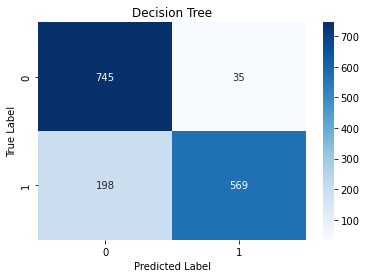

In [62]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [63]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869
5,Decision Tree,0.849386,0.741851,0.942053,0.830051


##### talk about results _________________________________________

## Model 5 - Random Forest

In [64]:
#model name for score keeping
model_name = 'Random Forest'

#parameters:
model_params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', RandomForestClassifier(random_state=42))])

############################################################################################

params = [tfidf_params, model_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                         {'clf__max_depth': [None, 3, 4, 10],
                          'clf__max_features': [2, 5, 10],
                          'clf__n_estimators': [10, 100, 1000]}],
             scoring='accuracy', verbose=True)

In [65]:
#see what hyperparameters were selected for best score
gscv.best_params_

{'vectorizer__max_df': 0.25,
 'vectorizer__max_features': None,
 'vectorizer__ngram_range': (1, 1)}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       780
           1       0.89      0.86      0.87       767

    accuracy                           0.88      1547
   macro avg       0.88      0.88      0.88      1547
weighted avg       0.88      0.88      0.88      1547



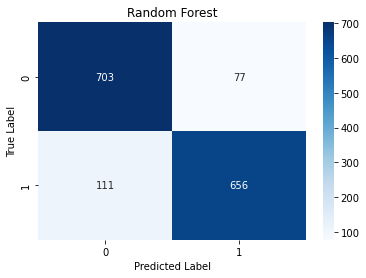

In [66]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [67]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869
5,Decision Tree,0.849386,0.741851,0.942053,0.830051
6,Random Forest,0.878474,0.855280,0.894952,0.874667


##### talk about results _________________________________________

## Model 6 - Support Vector Classification

In [68]:
#model name for score keeping
model_name = 'SVC'

#create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('clf', SVC())])

############################################################################################

params = [tfidf_params]

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'vectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
                          'vectorizer__max_features': (None, 50, 100, 200, 300),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}],
             scoring='accuracy', verbose=True)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       780
           1       0.96      0.86      0.91       767

    accuracy                           0.91      1547
   macro avg       0.92      0.91      0.91      1547
weighted avg       0.92      0.91      0.91      1547



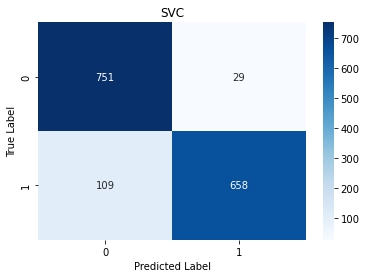

In [69]:
#predict on test data
y_pred = gscv.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [70]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869
5,Decision Tree,0.849386,0.741851,0.942053,0.830051
6,Random Forest,0.878474,0.855280,0.894952,0.874667
7,SVC,0.910795,0.857888,0.957787,0.905089


##### talk about results _________________________________________

## Strongest Model Analysis

-look at score_df

-also look at conf matrices in a graph

In [71]:
#compare models all using same dataset:
score_df.drop([0,1], axis=0).sort_values(by=['Accuracy'], ascending=False).style.hide_index()

Name,Accuracy,Recall,Precision,F1
LogReg,0.915966,0.887875,0.939310,0.912869
SVC,0.910795,0.857888,0.957787,0.905089
Random Forest,0.878474,0.855280,0.894952,0.874667
Tuned MNB,0.864900,0.963494,0.803261,0.876111
Decision Tree,0.849386,0.741851,0.942053,0.830051
Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799


Text(0.5, 1.0, 'Acc: 87.7% | F1: 87.3%')

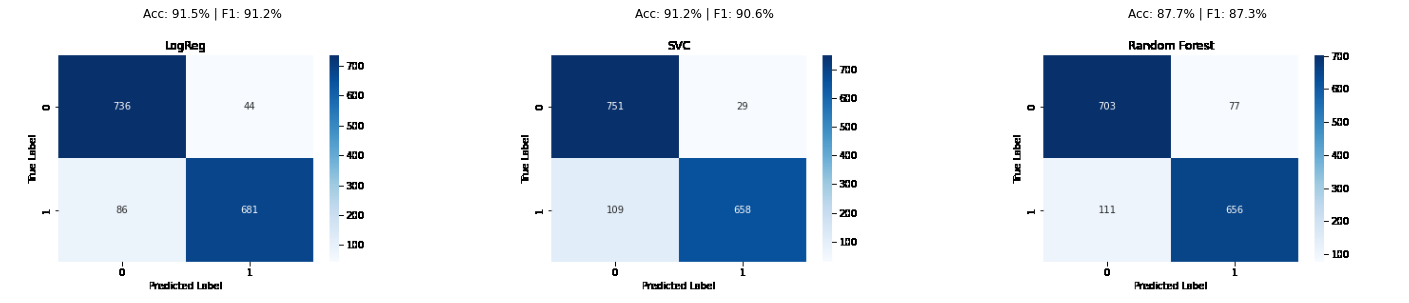

In [72]:
# show top 3 confusion:


# create figure
fig = plt.figure(figsize=(25, 10))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = cv2.imread('./img/LogReg.png')
RGB_img1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.imread('./img/SVC.png')
RGB_img2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
Image3 = cv2.imread('./img/Random Forest.png')
RGB_img3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(RGB_img1)
plt.axis('off')
plt.title("Acc: 91.5% | F1: 91.2%")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(RGB_img2)
plt.axis('off')
plt.title("Acc: 91.2% | F1: 90.6%")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(RGB_img3)
plt.axis('off')
plt.title("Acc: 87.7% | F1: 87.3%")

##### splain _______________________________

In [73]:
X = df['rejoined_post_removal']
y = df['is_depression']
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', LogisticRegression(C =4.6415888336127775, penalty = 'l2'))
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', LogisticRegression(C=4.6415888336127775))])

In [74]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

#sort in descending order, to see which coefficient most affects the positive class prediction
coefficient_df.sort_values(by='coefficients', ascending=False)[:15]

,feature,coefficients
14,die,3.962775
29,fucking,3.605571
55,month,3.461664
47,life,3.339217
3,anyone,3.272330
40,help,3.210058
25,felt,3.139316
10,care,3.095220
0,also,2.914546
49,live,2.778463


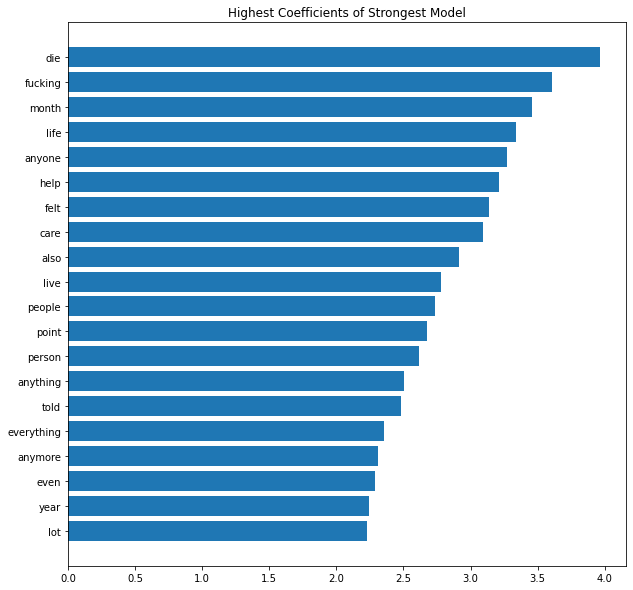

<Figure size 432x288 with 0 Axes>

In [75]:
coefs = coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(coefs['feature'], coefs['coefficients'])
plt.title('Highest Coefficients of Strongest Model')

# Show Plot
plt.show()

figname='coef-FinalModel'
plt.savefig('./img/'+figname+'.png')

##### commentary __________________________________________

##### WITH PROBLEMATIC WORDS: _____________________

In [76]:
X = df['rejoined']
y = df['is_depression']
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', TfidfVectorizer(max_features=100)),
                          ('clf', LogisticRegression(C =4.6415888336127775, penalty = 'l2'))
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=100)),
                ('clf', LogisticRegression(C=4.6415888336127775))])

In [77]:
coefs

,feature,coefficients
14,die,3.962775
29,fucking,3.605571
55,month,3.461664
47,life,3.339217
3,anyone,3.272330
40,help,3.210058
25,felt,3.139316
10,care,3.095220
0,also,2.914546
49,live,2.778463


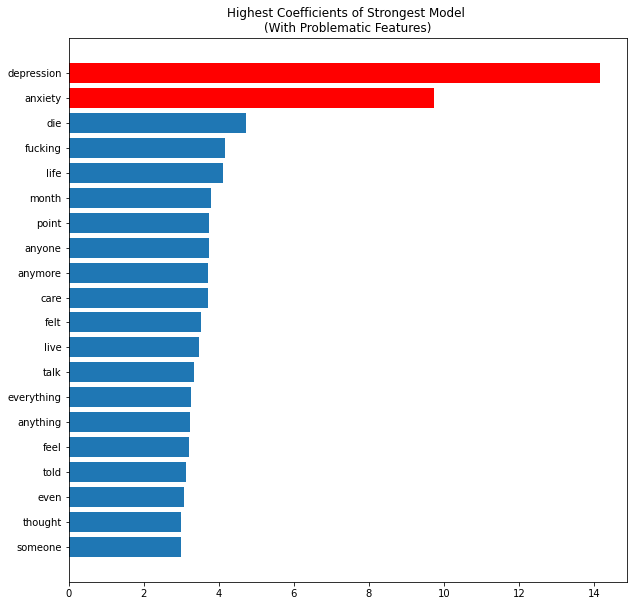

<Figure size 432x288 with 0 Axes>

In [78]:
coefficient_df = pd.DataFrame()
coefficient_df['feature'] = pipe['vectorizer'].get_feature_names()
coefficient_df['coefficients'] = pipe['clf'].coef_.T

coefs = coefficient_df.sort_values(by='coefficients', ascending=False)[:20]

###########################################################
problem_colors = ['#1f77b4' if (x < 6) else 'red' for x in coefs['coefficients'] ]

fig = plt.figure(figsize =(10, 10))
plt.gca().invert_yaxis()
plt.barh(coefs['feature'], coefs['coefficients'], color = problem_colors)
plt.title('Highest Coefficients of Strongest Model \n(With Problematic Features)')

# Show Plot
plt.show()

figname='coef-FinalModel-withProblematic'
plt.savefig('./img/'+figname+'.png')

##### commentary __________________________________________

In [79]:
#discuss findings, next steps

## _______________________________________ bigrams, trigrams with prominence

In [80]:
all_words_dep = sum(depressed_df['tokenized_no_stops'], [])

In [81]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bi_finder = BigramCollocationFinder.from_words(all_words_dep)
bi_scored = bi_finder.score_ngrams(bigram_measures.raw_freq)
bi_scored[:20]

[(('feel', 'like'), 0.005140556008753188),
 (('gon', 'na'), 0.0009970347926297116),
 (('http', 'co'), 0.0009366084415612443),
 (('mental', 'health'), 0.0009107114339604725),
 (('wan', 'na'), 0.0009063952660270106),
 (('panic', 'attack'), 0.0008934467622266247),
 (('even', 'though'), 0.000677638365553527),
 (('make', 'feel'), 0.000677638365553527),
 (('anyone', 'else'), 0.0006646898617531411),
 (('every', 'day'), 0.0006517413579527553),
 (('year', 'old'), 0.0006387928541523694),
 (('get', 'better'), 0.0006344766862189074),
 (('year', 'ago'), 0.0005567856634165922),
 (('felt', 'like'), 0.0005524694954831302),
 (('last', 'year'), 0.0005438371596162064),
 (('depression', 'anxiety'), 0.0005308886558158205),
 (('want', 'die'), 0.0005093078161485107),
 (('anxiety', 'depression'), 0.0004877269764812009),
 (('every', 'time'), 0.0004877269764812009),
 (('best', 'friend'), 0.0004704623047473531)]

##### ____________________

In [82]:
remove_words = ['na', 'http', 'com']
all_words_dep = [word for word in all_words_dep if word not in remove_words]

In [84]:
bi_finder = BigramCollocationFinder.from_words(all_words_dep)
bi_scored = bi_finder.score_ngrams(bigram_measures.raw_freq)
bi_scored[:20]

[(('feel', 'like'), 0.005157228347002225),
 (('mental', 'health'), 0.0009136651395612675),
 (('panic', 'attack'), 0.0008963444734084473),
 (('even', 'though'), 0.0006798361464981943),
 (('make', 'feel'), 0.0006798361464981943),
 (('anyone', 'else'), 0.0006668456468835791),
 (('every', 'day'), 0.000653855147268964),
 (('year', 'old'), 0.0006408646476543488),
 (('get', 'better'), 0.0006365344811161437),
 (('year', 'ago'), 0.0005585914834284526),
 (('felt', 'like'), 0.0005542613168902476),
 (('last', 'year'), 0.0005456009838138375),
 (('depression', 'anxiety'), 0.0005326104841992223),
 (('want', 'die'), 0.000510959651508197),
 (('anxiety', 'depression'), 0.0004893088188171717),
 (('every', 'time'), 0.0004893088188171717),
 (('best', 'friend'), 0.0004719881526643515),
 (('wish', 'could'), 0.00046332781958794133),
 (('first', 'time'), 0.0004589976530497363),
 (('high', 'school'), 0.0004200261542058908)]

##### ____________________

In [85]:
all_words_undiag = sum(undiag_df['tokenized_no_stops'], [])
all_words_undiag = [word for word in all_words_undiag if word not in remove_words]

In [86]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bi_finder = BigramCollocationFinder.from_words(all_words_undiag)
bi_scored = bi_finder.score_ngrams(bigram_measures.raw_freq)
bi_scored[:20]

[(('last', 'night'), 0.0013662112629123624),
 (('feel', 'like'), 0.0011996001332889037),
 (('got', 'ta'), 0.0007664111962679107),
 (('sorry', 'hear'), 0.0007664111962679107),
 (('want', 'go'), 0.0006997667444185271),
 (('wish', 'could'), 0.0005998000666444518),
 (('wan', 'go'), 0.0005331556147950683),
 (('cant', 'sleep'), 0.0004998333888703765),
 (('kal', 'penn'), 0.0004998333888703765),
 (('look', 'like'), 0.0004998333888703765),
 (('looking', 'forward'), 0.0004998333888703765),
 (('come', 'back'), 0.0004665111629456848),
 (('go', 'work'), 0.0004665111629456848),
 (('good', 'morning'), 0.0004665111629456848),
 (('back', 'work'), 0.000433188937020993),
 (('go', 'back'), 0.000433188937020993),
 (('go', 'sleep'), 0.000433188937020993),
 (('going', 'sleep'), 0.000433188937020993),
 (('go', 'bed'), 0.0003998667110963012),
 (('go', 'school'), 0.00036654448517160944)]

In [87]:
pmi_finder = BigramCollocationFinder.from_words(all_words_dep)
pmi_finder.apply_freq_filter(5)
pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)
pmi_scored[:20]

[(('eyed', 'gyel'), 15.495217962366517),
 (('tik', 'tok'), 15.009791135196274),
 (('vice', 'versa'), 15.009791135196274),
 (('executive', 'dysfunction'), 14.554111651420085),
 (('fmwangyisaveindianstudents', 'takeusbacktochina'), 14.495217962366517),
 (('brown', 'eyed'), 14.357714438616581),
 (('impending', 'doom'), 14.30257288442412),
 (('border', 'restricted'), 14.232183556532721),
 (('bla', 'bla'), 14.13907415214124),
 (('manchester', 'united'), 14.116706339112785),
 (('connects', 'certified'), 14.009791135196274),
 (('razor', 'blade'), 13.817146057253877),
 (('stats', 'feed'), 13.817146057253876),
 (('gna', 'gna'), 13.705637742036886),
 (('clinically', 'defined'), 13.36711313661883),
 (('sexually', 'assaulted'), 13.325292960924202),
 (('slit', 'wrist'), 13.232183556532721),
 (('outpatient', 'program'), 13.116706339112783),
 (('dozen', 'clinically'), 13.06225855509041),
 (('essentially', 'connects'), 12.959165062126305)]

##### _________________________________

##### _________________________________________________-

explain need for word embeddings

# Word Embeddings

##### explain _________________________________________________________

## Word2Vec

#### window size ________________________________
explain similarity to n grams from earlier

##### ______________________________________________________

explain why we are using full dataset (with 'depression' etc)

In [88]:
model_name='W2V Model'

w2v_X=df['tokenized']
w2v_model = Word2Vec(w2v_X, vector_size=100, window=5, min_count=2)

w2v_model.wv.index_to_key[:20]

['i',
 'to',
 'and',
 'a',
 'the',
 'my',
 'it',
 'of',
 't',
 'me',
 'that',
 'in',
 'm',
 'but',
 'is',
 'for',
 'have',
 'this',
 'just',
 'so']

In [89]:
w2v_model.wv.most_similar('depression')

[('social', 0.7376829981803894),
 ('stress', 0.7138948440551758),
 ('physical', 0.6955088376998901),
 ('mental', 0.6923004388809204),
 ('trauma', 0.6863161325454712),
 ('disorder', 0.6822684407234192),
 ('health', 0.6773921251296997),
 ('adhd', 0.6724864840507507),
 ('slamming', 0.6718602776527405),
 ('fuelled', 0.6697007417678833)]

In [90]:
w2v_model.wv.most_similar('anxiety')

[('mental', 0.7923803925514221),
 ('dealing', 0.7383059859275818),
 ('issue', 0.7340943217277527),
 ('adhd', 0.6978169679641724),
 ('panic', 0.6966753005981445),
 ('trifecta', 0.692802906036377),
 ('self', 0.6902989149093628),
 ('symptom', 0.6824393272399902),
 ('heart', 0.6823240518569946),
 ('struggled', 0.6662394404411316)]

##### explain why we will use pre trained


## GLOVE, PRETRAINED, EXPLAIN ___________________________________

__using both 50-dimensonal and 100-dimensional__

In [91]:
#get total vocabulary of our data so that we only take words we need:

#tokenized data with all words
X=df['tokenized']
y=df['is_depression']

#split current data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [92]:
#get total vocabulary of entire training 
total_vocabulary = set(word for entry in X for word in entry)

#show total vocab:
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 18775 unique tokens in the dataset.


In [93]:
#search glove.6B.50d data for our own words:
glove50 = {}
with open('./data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove50[word] = vector
            
#same with 100d data
glove100 = {}
with open('./data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove100[word] = vector

In [94]:
glove50['depression']

array([ 0.81539 ,  0.31056 , -0.25971 , -1.2212  , -1.7488  ,  0.68802 ,
        0.39753 ,  0.17298 , -0.097186,  0.28354 ,  0.25045 ,  0.20969 ,
       -0.019338, -0.33467 , -0.038643, -0.011519, -1.6151  , -0.30461 ,
       -0.50434 ,  0.66403 , -0.67055 ,  0.15239 ,  0.52831 , -0.25426 ,
        0.50801 , -0.83183 , -0.43301 , -0.18163 ,  0.95466 ,  1.4164  ,
        2.313   ,  0.23765 ,  0.86228 , -1.2755  , -0.52824 , -0.15141 ,
       -0.50096 , -0.30892 ,  1.1232  , -0.32011 , -1.2358  , -0.19507 ,
        0.51594 ,  0.46977 ,  0.28115 ,  0.44771 ,  0.75517 , -1.2266  ,
       -0.010493,  0.5018  ], dtype=float32)

In [95]:
glove100['depression']

array([ 0.10542  , -0.13691  ,  0.15946  ,  0.99195  , -1.1368   ,
        0.18614  ,  0.036245 , -0.6107   , -0.091113 , -0.52332  ,
        0.030946 , -0.35659  , -0.44533  , -0.12095  ,  1.7213   ,
       -0.27306  ,  0.502    , -0.45359  , -0.37612  , -0.36712  ,
        0.32663  ,  0.56371  , -0.58183  ,  0.39254  , -0.48831  ,
        0.4093   , -0.0067719, -1.1515   , -0.33624  ,  0.25515  ,
        0.48866  ,  0.47035  ,  0.046441 ,  0.042582 , -1.1799   ,
        0.19842  ,  0.57576  , -0.28609  , -0.090024 ,  0.61114  ,
       -0.8027   ,  0.097761 , -0.35865  , -0.29034  ,  0.76079  ,
        0.42944  ,  1.1057   ,  0.34321  ,  0.40805  , -0.47787  ,
       -0.63205  , -0.17783  ,  0.050688 ,  0.795    ,  0.84402  ,
       -1.5069   ,  0.51453  , -0.50486  ,  0.56217  ,  1.1522   ,
        0.24492  ,  1.8298   ,  0.33141  , -0.69176  ,  0.27301  ,
        0.629    , -0.015768 , -0.95589  ,  1.0203   , -0.54593  ,
       -0.28555  ,  0.099894 , -0.32071  ,  0.73616  , -0.0568

In [96]:
#example of glove pre-trained model's similar words:

def find_closest_embeddings(embedding):
    return sorted(glove50.keys(), key=lambda word: spatial.distance.euclidean(glove50[word], embedding))

find_closest_embeddings(glove50["depression"])[:10]

['depression',
 'onset',
 'alcoholism',
 'illness',
 'severe',
 'debilitating',
 'experiencing',
 'fever',
 'anxiety',
 'worsened']

##### explain need for mean word embeddings _______________________________________________________________--

In [97]:
# Creating Mean Word Embeddings
# For this step, it's worth the extra effort to write your own mean embedding vectorizer class, so that you can make use of pipelines from scikit-learn. Using pipelines will save us time and make the code a bit cleaner.

# The code for a mean embedding vectorizer class is included below, with comments explaining what each step is doing. Take a minute to examine it and try to understand what the code is doing.y

In [98]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove50))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

### Glove Model 1 - LogReg

In [99]:
#model name for score keeping
model_name = 'Glove-50 LogReg'

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove50)),
                          ('clf', LogisticRegression(C =4.6415888336127775, penalty = 'l2', max_iter=1000))
                         ])

#fit to data
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000022B5539A5B0>),
                ('clf',
                 LogisticRegression(C=4.6415888336127775, max_iter=1000))])

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       780
           1       0.81      0.86      0.83       767

    accuracy                           0.83      1547
   macro avg       0.83      0.83      0.83      1547
weighted avg       0.83      0.83      0.83      1547



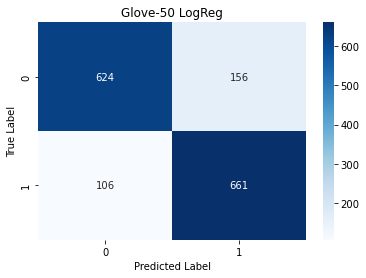

In [100]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

### Selecting a More Fitting Model _________________________________________________

In [101]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove50)),
              ('Logistic Regression', LogisticRegression())])

models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [102]:
scores

[('Random Forest', 0.9007115135834411),
 ('Support Vector Machine', 0.8727360931435963),
 ('Logistic Regression', 0.8177554980595084)]

### Glove Model 2 - Random Forest

In [103]:
#gridsearch on best model:

#model name for score keeping
model_name = 'Glove-50 Random Forest'


params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove50)),
                          ('clf', RandomForestClassifier(random_state=42))
                         ])

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)


#fit to data
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000022B49DCCD00>),
                ('clf', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       780
           1       0.95      0.85      0.90       767

    accuracy                           0.90      1547
   macro avg       0.91      0.90      0.90      1547
weighted avg       0.91      0.90      0.90      1547



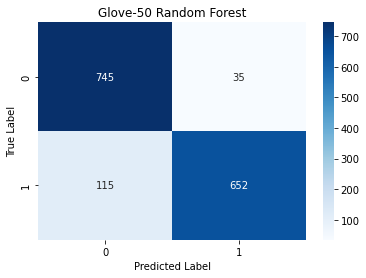

In [104]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [105]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869
5,Decision Tree,0.849386,0.741851,0.942053,0.830051
6,Random Forest,0.878474,0.855280,0.894952,0.874667
7,SVC,0.910795,0.857888,0.957787,0.905089
8,Glove-50 Random Forest,0.903038,0.850065,0.949054,0.896836


##### explain ________________________________

In [106]:
#gridsearch on best model:

#model name for score keeping
model_name = 'Glove-100 Random Forest'


params = {
    'clf__n_estimators': [10,100,1000],
    'clf__max_depth': [None, 3, 4, 10],
    'clf__max_features': [2, 5, 10]
    
}

#remake LogReg model with best parameters from earlier gridsearch
pipe = Pipeline([('vectorizer', W2vVectorizer(glove100)),
                          ('clf', RandomForestClassifier(random_state=42))
                         ])

#gridsearch
gscv = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, verbose=True, scoring = 'accuracy')
gscv.fit(X_train, y_train)


#fit to data
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('vectorizer',
                 <__main__.W2vVectorizer object at 0x0000022B49B20220>),
                ('clf', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       780
           1       0.97      0.87      0.92       767

    accuracy                           0.92      1547
   macro avg       0.93      0.92      0.92      1547
weighted avg       0.93      0.92      0.92      1547



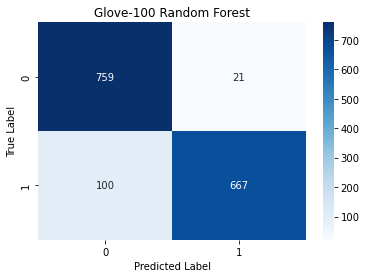

In [107]:
#predict on test data
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion(model_name)

In [108]:
score_df = score_df.append(update_score_df(model_name), ignore_index=True)
score_df

,Name,Accuracy,Recall,Precision,F1
0,Baseline - MultiNB,0.683258,0.720991,0.667069,0.692982
1,Baseline No Stops,0.833226,0.869622,0.808485,0.837940
2,Baseline Adjusted Data,0.741435,0.726206,0.745649,0.735799
3,Tuned MNB,0.864900,0.963494,0.803261,0.876111
4,LogReg,0.915966,0.887875,0.939310,0.912869
5,Decision Tree,0.849386,0.741851,0.942053,0.830051
6,Random Forest,0.878474,0.855280,0.894952,0.874667
7,SVC,0.910795,0.857888,0.957787,0.905089
8,Glove-50 Random Forest,0.903038,0.850065,0.949054,0.896836
9,Glove-100 Random Forest,0.921784,0.869622,0.969477,0.916838


##### explain ________________________________

##### coefficients ________________________________________

In [109]:
type(W2vVectorizer(glove50))

__main__.W2vVectorizer

In [110]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

***
***

# Conclusion


remember to include detailed info in into, conclusion, readme about all models and methods used
##### __________________________________________________________________________________